In [226]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Load Data

In [227]:
df = pd.read_csv('top_1000_tiktokers.csv')
df.head()

,Rank,Username,Tiktok Link,Name,Subscribers Count,Views. Avg,Likes. Avg,Comments. Avg,Shares. Avg
0,1,badbunny,https://www.tiktok.com/@badbunny,Bad Bunny,23.4M,63.1M,10.3M,65.2K,108.6K
1,2,noahschnapp,https://www.tiktok.com/@noahschnapp,Noah Schnapp,26.1M,23.4M,4.8M,46.7K,22.1K
2,3,khaby.lame,https://www.tiktok.com/@khaby.lame,Khabane lame,145.9M,47.5M,2.5M,46K,9.4K
3,4,coopernoriega,https://www.tiktok.com/@coopernoriega,Cooper Noriega,3.2M,31M,1.3M,120.9K,8.4K
4,5,avrillavigne,https://www.tiktok.com/@avrillavigne,Avril Lavigne,4M,24.7M,3.5M,32.1K,22.7K


In [228]:
df.drop(['Username', 'Tiktok Link', 'Name'], axis=1, inplace=True)
df.head()

,Rank,Subscribers Count,Views. Avg,Likes. Avg,Comments. Avg,Shares. Avg
0,1,23.4M,63.1M,10.3M,65.2K,108.6K
1,2,26.1M,23.4M,4.8M,46.7K,22.1K
2,3,145.9M,47.5M,2.5M,46K,9.4K
3,4,3.2M,31M,1.3M,120.9K,8.4K
4,5,4M,24.7M,3.5M,32.1K,22.7K


## Fix Data Types

In [229]:
df.dtypes

Rank                  int64
Subscribers Count    object
Views. Avg           object
Likes. Avg           object
Comments. Avg        object
Shares. Avg          object
dtype: object

In [230]:
# non-target features
x_cols = df.columns[1:]

for col in x_cols:
    col_suffixes = list(set([suffix for suffix in df[col].str[-1] if suffix.isalpha()]))
    print(f'Unique suffixes for {col}: {col_suffixes}')

Unique suffixes for Subscribers Count: ['M', 'K']
Unique suffixes for Views. Avg: ['M', 'K']
Unique suffixes for Likes. Avg: ['M', 'K']
Unique suffixes for Comments. Avg: ['K']
Unique suffixes for Shares. Avg: ['K']


In [231]:
def str_to_float(str_num):
    if type(str_num) == str:
        if str_num[-1] == 'M':
            return float(str_num[:-1]) * 1_000_000
        elif  str_num[-1] == 'K':
            return float(str_num[:-1]) *1_000
        else:
            return float(str_num)
    else:
        return str_num

thousand_ex = '10.3K'
mill_ex = '324.5M'
hund_ex = '123'

print(f'{thousand_ex} becomes {str_to_float(thousand_ex)}')
print(f'{mill_ex} becomes {str_to_float(mill_ex)}')
print(f'{hund_ex} becomes {str_to_float(hund_ex)}')

10.3K becomes 10300.0
324.5M becomes 324500000.0
123 becomes 123.0


In [232]:
for col in df.columns[1:]:
    df[col] = df[col].map(lambda x: str_to_float(x))

df.head()

,Rank,Subscribers Count,Views. Avg,Likes. Avg,Comments. Avg,Shares. Avg
0,1,23400000.0,63100000.0,10300000.0,65200.0,108600.0
1,2,26100000.0,23400000.0,4800000.0,46700.0,22100.0
2,3,145900000.0,47500000.0,2500000.0,46000.0,9400.0
3,4,3200000.0,31000000.0,1300000.0,120900.0,8400.0
4,5,4000000.0,24700000.0,3500000.0,32100.0,22700.0


# Exploratory Data Analysis

In [233]:
df[x_cols].describe()

,Subscribers Count,Views. Avg,Likes. Avg,Comments. Avg,Shares. Avg
count,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,6.906116e+06,3.330490e+06,3.995059e+05,3464.326000,3649.304000
std,1.139041e+07,3.514470e+06,4.632153e+05,6389.809003,6019.052223
min,3.700000e+03,6.679000e+05,4.570000e+04,0.000000,95.000000
25%,1.300000e+06,1.800000e+06,2.232500e+05,1200.000000,928.500000
50%,3.500000e+06,2.600000e+06,3.049000e+05,2000.000000,1900.000000
75%,7.925000e+06,3.700000e+06,4.372250e+05,3400.000000,3900.000000
max,1.459000e+08,6.310000e+07,1.030000e+07,120900.000000,108600.000000


## Univariate Analysis

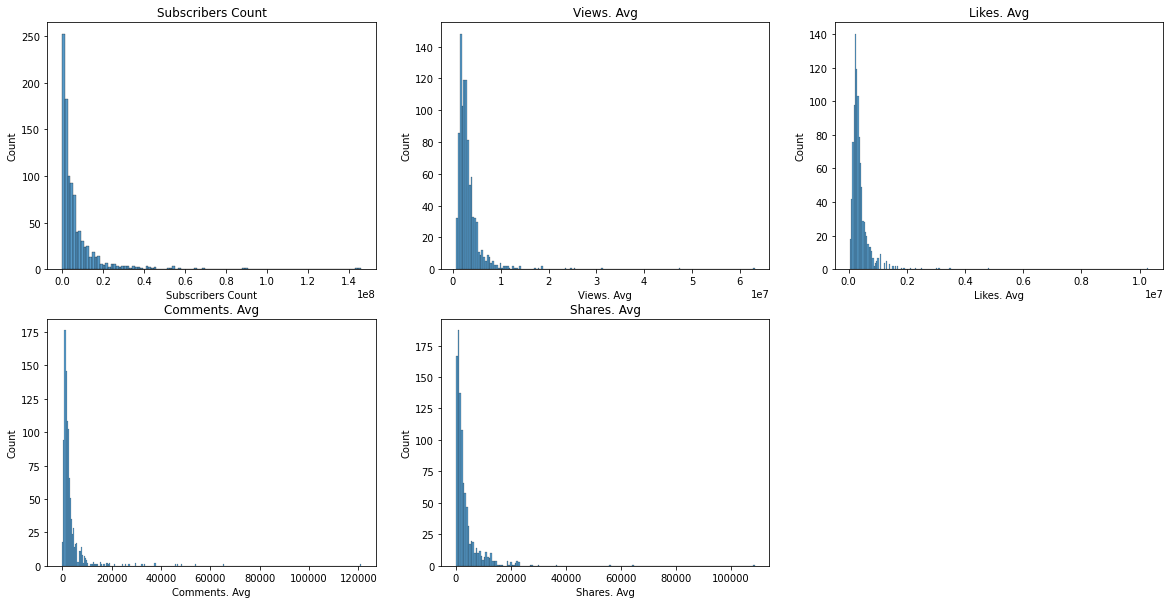

In [254]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
for col, ax in zip(x_cols, np.ravel(axes)):
    sns.histplot(data=df, x=col, ax=ax)
    ax.set_title(col)

axes[-1,-1].axis('off')
plt.show()

We see here that the distributions are all very right skewed, i.e. their medians are less than their means, with very long tails. However, this is expected, and we do not want to throw away any values as outliers. Typically, on social media apps like Tik Tok, a very small minority of users will far, far outperform even just moderately less popular users, and it appears that this is what we see here.

## Bivariate Analysis
Relationships between variables should be expected. Whether these relationships are linear is another question. Regarding the target variable, it only makes sense that rank would increase with an increase in subscribers, average views, etc. One would also expect, for example, likes, shares, and comments to go up with views. But when building linear models, a key question is whether one feature can be predicted from specifically a linear combination of others.

<AxesSubplot:>

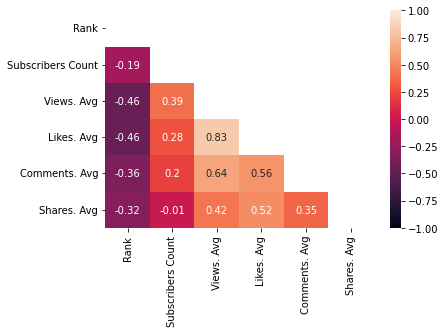

In [234]:
corr = df.corr()
mask = np.triu(corr)

sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=mask)

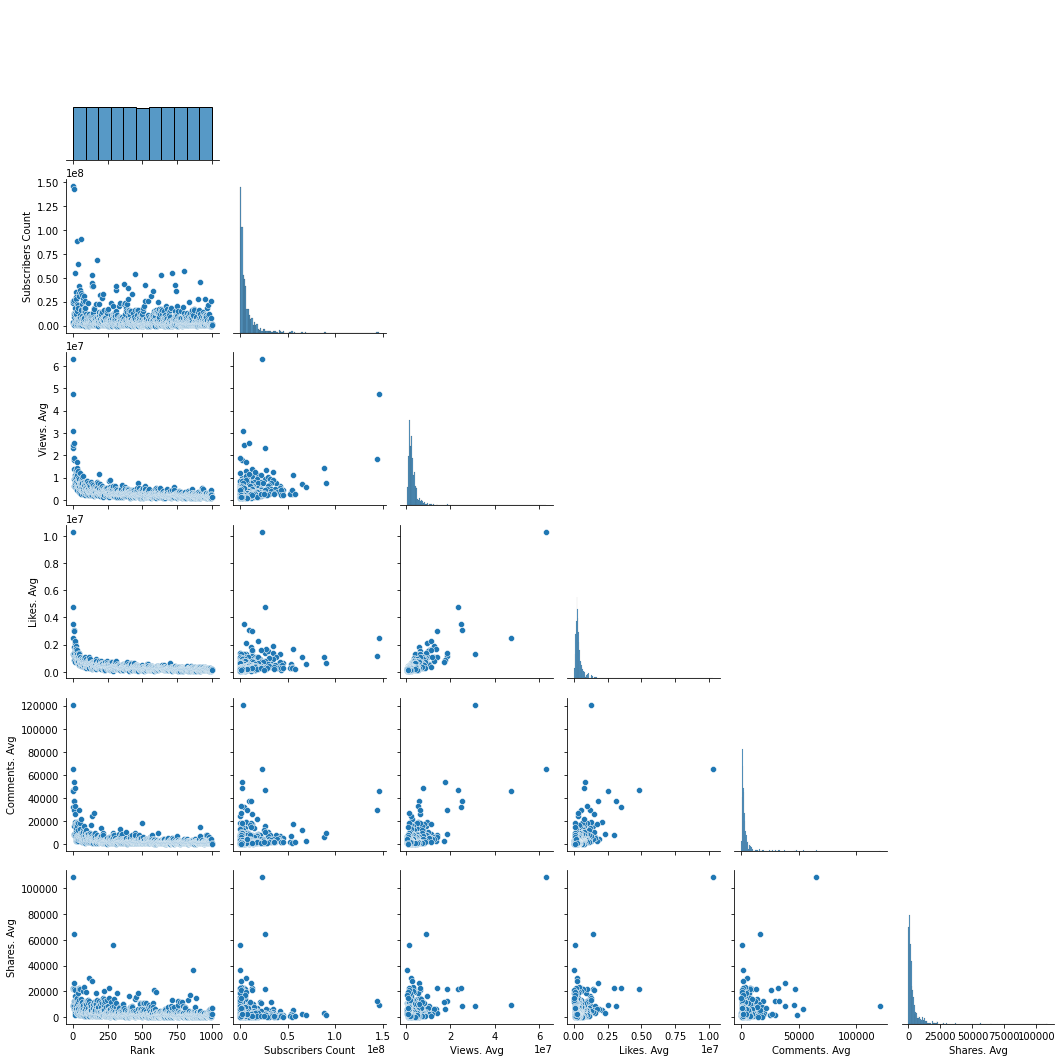

In [235]:
sns.pairplot(df, corner=True)

## Clustering
To cluster the data, I use k-means clustering. In k-means clustering, a centroids for clusters are chosen with the objective of minimizing the sum of distances between points in a cluster and the cluster's centroid. First some fixed number of clusters k is chosen. Second, k points are chosen to be cluster centroids. Third, points are assigned to their nearest centroid. Fourth, centroids are recomputed to be the center of each cluster. The third and fourth steps are then repeated until some maximum number of iterations has passed.

### Transforming Data for Clustering
At a basic level, k-means clustering cares about the distance between points. For this reason, each factor is scaled so it has mean of zero and standard deviation of 1. 

Additionally, while not required by k-means, I transform the data to become more normal using a Box Cox transformation. This will be useful for visualizations. For a feature $y$, the Box Cox transformation finds the value $\lambda$ that makes $y$ best approximate the normal distribution after the following transformation:

$\displaystyle y(\lambda)  =  \frac {{y}^{ \lambda} - 1}{\lambda} $ when $\lambda \neq 0$

 $y(\lambda) = log(y)$ when $\lambda = 0$



Transforming Subscribers Count with lambda = 0.17466759525241948
Transforming Views. Avg with lambda = -0.3552276470926497
Transforming Likes. Avg with lambda = -0.18576848974199864
Transforming Comments. Avg with lambda = 0.07319704734975091
Transforming Shares. Avg with lambda = -0.04638530260865479


C:\Users\Patrick\AppData\Local\Temp/ipykernel_11728/3008832432.py:15: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_boxcox.hist(ax=ax)


Below are histograms of the transformed features


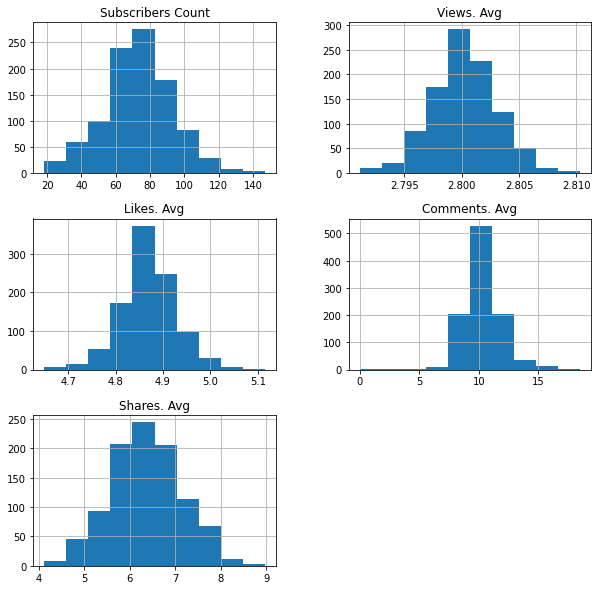

In [277]:
def df_boxcox_transform(df):
    df_vals = np.zeros(df.shape)
    for i, col in enumerate(df.columns):
        # Add a constant to avoid log(0)
        values, l = stats.boxcox(df[col]+1)
        print(f'Transforming {col} with lambda = {l}')
        df_vals[:, i] = values
    df_transformed = pd.DataFrame(df_vals, columns=df.columns)
    return df_transformed

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
df_boxcox = df_boxcox_transform(df[x_cols])
df_boxcox.hist(ax=ax)
print('Below are histograms of the transformed features')

plt.show()

We can visually confirm that the features look at least much more normal than before. Additionally, we can see what kind of transformation was performed on each feature.

### Selecting k
As stated above, k-means requires a pre-selected value for k. The value for k is chosen here using the "elbow method." Clustering is performed for a range of k values between 1 and 20. For each value of k, the sum of squared distances of samples to the closest cluster centroid is plotted. The expectation is that this quantity should first decrease quickly as k decreases then begin to decrease more slowly. The number k chosen when the decrease begins to slow down. The goal of k-means begin to decrease the sum of squared distances from samples to cluster centroids but also wanting to have useful clusters, k is chosen at a point when the benefit of adding a new cluster begins to decrease substantially. On the ideal plot, k would look like an elbow before a plateau.

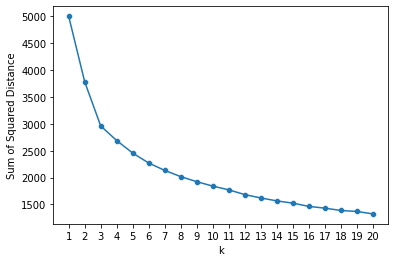

In [278]:
ss = StandardScaler()

# Scale so mean=0 std=1
scaled_values = ss.fit_transform(df_boxcox)

k_range = range(1, 21)

sse = []
for k in k_range:
    kmeans = KMeans(k, random_state=123)
    kmeans.fit(scaled_values)

    sse.append(kmeans.inertia_)

sns.lineplot(x=k_range, y=sse)
sns.scatterplot(x=k_range, y=sse)
plt.ylabel('Sum of Squared Distance')
plt.xlabel('k')
plt.xticks(k_range)
plt.show()

I chioose k=3. Note how from k=1 to k=2, the sum of squared distances decreases substantially, as it does from k=2 to k=3. But after that, the decrease begins to slow down greatly. This is how we know that k=3 is the "elbow."

### Finding and Examining CLusters
Here clusters are found using the value k=3 selected above. After computing the clusters, the mean and standard deviation for each feature and each cluster are presented and discussed.

In [238]:
kmeans = KMeans(3, random_state=123)
kmeans.fit(scaled_values)

df_scaled = pd.DataFrame(scaled_values, columns=x_cols)
df_scaled['cluster assignment'] = kmeans.labels_

In [268]:
df['cluster assignments'] = kmeans.labels_
agg_cluster_stats = df.groupby('cluster assignments').agg(['mean', 'std', 'count']).round(2)
df.drop('cluster assignments', axis=1, inplace=True)
agg_cluster_stats

Rank               Subscribers Count               \
                       mean     std count              mean          std   
cluster assignments                                                        
0                    623.76  241.05   315        1875060.32   2312054.39   
1                    590.92  223.18   475        7869168.63   8723429.28   
2                    111.10   68.00   210       12274364.76  19243736.39   

                           Views. Avg                   Likes. Avg             \
                    count        mean         std count       mean        std   
cluster assignments                                                             
0                     315  1785691.75   731533.76   315  218053.02   90206.61   
1                     475  2957045.68  1172214.18   475  329619.16  121658.71   
2                     210  6492380.95  6415571.60   210  829762.38  856208.53   

                          Comments. Avg                 Shares. Avg           \
                    count          mean       std count        mean      std   
cluster assignments                                                            
0                     315       2411.35   1850.78   315     5416.90  5707.20   
1                     475       1926.43   1598.70   475     1143.57   850.92   
2                     210       8522.38  12307.17   210     6665.64  9719.68   

                           
                    count  
cluster assignments        
0                     315  
1                     475  
2                     210

While the mean and standard deviation are discussed below, first note the cluster membership. While the cluster membership is not completely balanced, each cluster contains a decent number of samples, which is a good initial sanity check suggesting the clustering did not at least go horribly wrong.

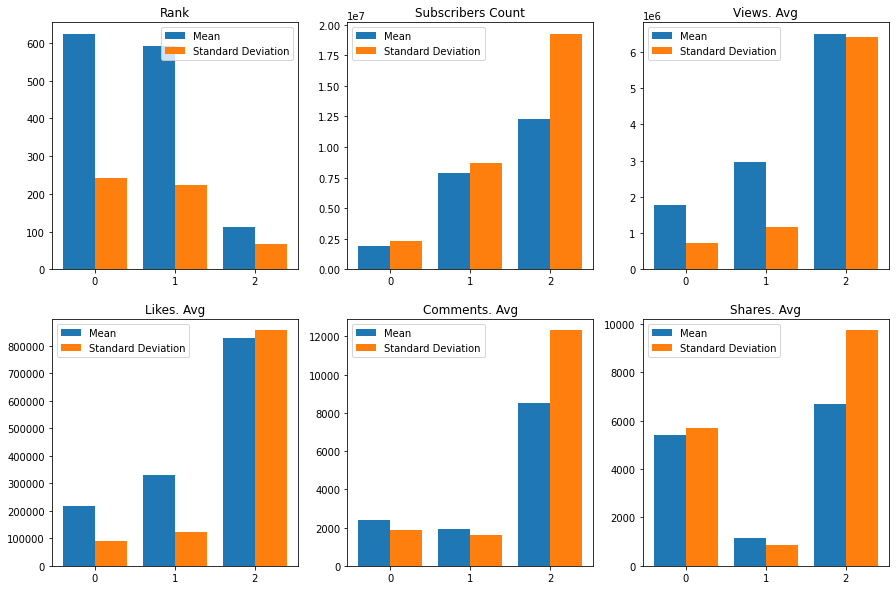

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))

for col, ax in zip(df.columns, np.ravel(axes)):
    x_ix = np.arange(agg_cluster_stats[col]['std'].shape[0])
    ax.bar(x=x_ix-0.2, height=agg_cluster_stats[col]['mean'].values, width=0.4, label='Mean')
    ax.bar(x=x_ix+0.2, height=agg_cluster_stats[col]['std'].values, width=0.4, label='Standard Deviation')
    ax.set_xticks(ticks=x_ix)
    ax.set_title(col)
    ax.legend()

From the above, the clusters can be described as followed:
* The 0th cluster has a fairly low mean rank. Relative to the other clusters, it consists of users with the fewest subcribers and low mean numbers of views, likes, and comments. HOwever, it has a relatively high mean number of shares, albeit with a high standard deviation on the distribution of shares.
* The 1st cluster has a similar mean rank to the 0th. However, it has a much lower mean number of average sharwes and higher subscriber counts and mean views. The mean number of average comments is similar to the 0th cluster.
* The 2nd cluster has the lowest mean rank and an accompanying low standard deviation, meaning it consists of higher ranked users. It has high values for subscriber counts and mean number of average views, likes, comments and shares. However, all of these values have very high associated standard deviation.

How this could potentially be interpreted is that among the lower ranked users in the top 1000 Tik Tok users, there are those that rely more on shares and those that rely more on consistent subscribers.

## Cluster Visualization
The clusters will be visualized using principal component analysis. Principal component analysis (PCA) is a dimension reduction technique. Specifically, PCA finds a number of orthogonal vectors called principal components. Each principal component explains some portion of the variability of the dataset, and all of the principal components explain all of the variance. The first principal components will explain the largest portion of the variance, the second a bit less, the third even less and so on. For visualizing clusters, typically the first two principal components are used, as they should produce show the most separability between clusters. Note that PCA assumes featurse are normally distributed with mean 0 and standard deviation of 1, but transformations to achieve these distributions were performed above.

The big downside of PCA is a loss of interpretability. The conceptual explanation of each principal component is just the direction that explains a certain amount of variance or a certain portion of total variance. That does not relate back to the original features. So while PCA can provide visual proof that clusters are separate, it provides little additional information about the clusters themselves.

In [260]:
# Perform PCA
pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df_scaled), columns=[f'pc_{i+1}' for i in range(df_scaled.shape[1])])
df_pca['cluster assignment'] = kmeans.labels_
df_pca.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,cluster assignment
0,6.564392,4.122539,-0.123903,0.604673,-0.311689,1.484061,2
1,5.720040,2.883934,-0.580752,0.174808,-0.274617,1.142076,2
2,6.384972,1.520812,-1.706691,0.962108,0.661988,1.442491,2
3,4.806829,3.511920,-0.734113,-1.935310,1.088440,0.904625,2
4,4.789878,3.228347,0.561380,-0.487372,-0.151255,0.835909,2


With the principal components shown, we can now check what portion of the variance each component explains.

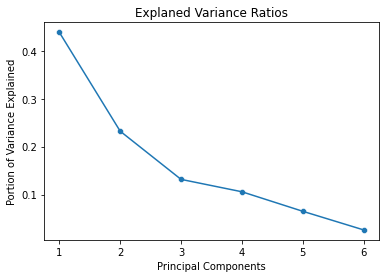

In [262]:
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_)+1), y=pca.explained_variance_ratio_)
sns.scatterplot(x=range(1, len(pca.explained_variance_ratio_)+1), y=pca.explained_variance_ratio_)
plt.title('Explaned Variance Ratios')
plt.ylabel('Portion of Variance Explained')
plt.xlabel('Principal Components')
plt.show()

While not an ideally shaped graph, this is about what to expect. Note how the first principal component explains a great deal more of the variance than the second, and the second explains relatively less than the third and so on. This is what is expected.

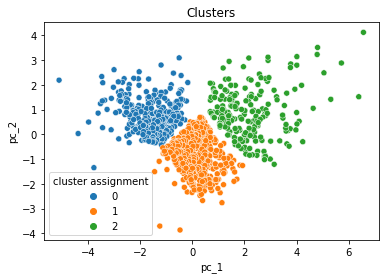

In [264]:
sns.scatterplot(data=df_pca, x='pc_1', y='pc_2', hue='cluster assignment', palette='tab10')
plt.title('Clusters')
plt.show()

Above we can see that the clusters are very nicely separated when the data is projected onto the principal components.